In [4]:
import pandas as pd

Dates = pd.date_range('2024-01-01','2024-12-31')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [12]:

def Solar_Declination(DOY):
  gamma = 2*np.pi/365*(DOY-1)
  delta = 0.006918 - 0.399912 * np.cos(gamma)+0.070257 *np.sin(gamma)-0.006758 *np.cos(2*gamma) + 0.000907*np.sin(2*gamma)-0.002697*np.cos(3*gamma)+0.00148 *np.sin(3*gamma)
  declination=delta*180/np.pi
  return(declination)

Dates = pd.date_range('2024-01-01','2024-12-31')
Dates = pd.date_range('2024-06-21','2024-06-22')
Declination = Solar_Declination(Dates.dayofyear)
Declination
# plt.figure()
# plt.plot(Dates,Declination)
# plt.ylabel('Solar Declination')

Index([23.175556231549727, 23.234160110071496], dtype='float64')

In [254]:
# from tzfpy import get_tz
# import pytz
# tzinfo = pytz.timezone(get_tz(-123.256,49.265))


from tzfpy import get_tz
from datetime import *
import pandas as pd
import pytz
import numpy as np

class Tzfuncs():
    # Takes an input timezone or auto-determines a (DST aware) timezone from lat/lon coordinates
    # Will convert to TZ aware "UTC_time" and "Local_Time" along with non-TZ aware / non DST "Standard_Time"

    def __init__(self,Time_Zone=None,lat_lon=None,DST=False):
        self.DST = DST
        self.lat_lon = lat_lon
        if Time_Zone is not None:
            self.Time_Zone = pytz.timezone(Time_Zone)
        elif self.lat_lon is not None:
            self.AssumeTZ(lat_lon[1],lat_lon[0])
        else:
            print(f'No Time Zone Info Provided')

    def AssumeTZ(self,lon,lat):
        self.DST=True
        print(f'Timezone not provided, estimating for {lon}, {lat}')
        self.Time_Zone = pytz.timezone(get_tz(lon,lat))

    def convert(self,Input_Time,from_UTC=False,to_UTC=False):
        if isinstance(Input_Time,pd.DatetimeIndex):
            Input_Time=Input_Time.to_series()
        if from_UTC == False:
            self.Local_Time=Input_Time
            self.to_StandardTime(to_UTC)
            if self.lat_lon is not None:
                self.get_LAT()
        else:
            self.UTC_Time=Input_Time
            self.fromUTC()

    def to_StandardTime(self,to_UTC=False):
        offset = self.Local_Time.apply(lambda x: self.Time_Zone.dst(x,is_dst=self.DST))
        if self.DST == True:
            self.Standard_Time = pd.DatetimeIndex(self.Local_Time-offset)
            self.Local_Time = self.Local_Time.apply(lambda x: self.Time_Zone.localize(x,is_dst=self.DST))
        else:
            self.Standard_Time = pd.DatetimeIndex(self.Local_Time)
            self.Local_Time = (self.Local_Time+offset).apply(lambda x: self.Time_Zone.localize(x,is_dst=self.DST))
        if to_UTC == True:
            self.toUTC()
        self.Local_Time = pd.DatetimeIndex(self.Local_Time)

    def toUTC(self):
        self.UTC_Time = pd.DatetimeIndex(self.Local_Time.apply(lambda x: x.astimezone(pytz.utc)))

    def fromUTC(self):
        self.UTC_Time = self.UTC_Time.apply(lambda x: pytz.utc.localize(x, is_dst=self.DST))
        self.Local_Time = self.UTC_Time.apply(lambda x: x.astimezone(self.Time_Zone).replace(tzinfo=None))
        self.to_StandardTime(to_UTC=False)
        self.UTC_Time = pd.DatetimeIndex(self.UTC_Time)
    
    def get_LAT(self):
        Meridian = pd.Series([15*t.utcoffset().total_seconds()/3600 for t in self.Local_Time])
        self.LST = self.Local_Time.hour*60+self.Local_Time.minute
        self.LMST = self.LST+(self.lat_lon[1]-Meridian)*4
        max_DOY = (self.Local_Time+pd.offsets.YearEnd()).dayofyear
        gamma = 2*np.pi/max_DOY*(self.Local_Time.dayofyear-1+(self.Local_Time.hour-12)/24)
        self.Delta_LAT = 229.18*(0.000075+0.001868*np.cos(gamma)-0.032077*np.sin(gamma)-0.014615*np.cos(2*gamma)-0.040849*np.sin(2*gamma))
        self.LAT = self.LMST-self.Delta_LAT

tz = Tzfuncs(lat_lon=[50,-127.5])
Dates = pd.date_range('2024-07-22 8:00','2024-07-22 9:00')
print()
tz.convert(Dates)
print(f'{int(np.floor(tz.LAT[0]/60))}:{int(tz.LAT[0]/60%1*60)}')

Timezone not provided, estimating for -127.5, 50

6:36


In [253]:
(Dates+ pd.offsets.YearEnd()).dayofyear 
# Dates

Index([366], dtype='int32')

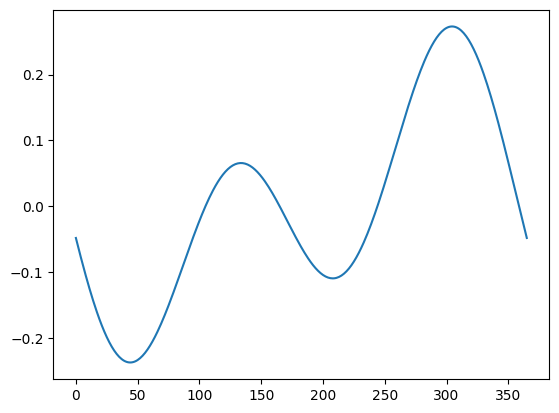

In [233]:
import matplotlib.pyplot as plt
Dates = pd.date_range('2024-01-01 12:00','2024-12-31 12:00')
tz.convert(Dates)
# tz.LAT

plt.figure()
plt.plot(tz.Delta_LAT/60)
# plt.plot(tz.LAT_alt/60)
# tz.LMST

In [272]:
import pandas as pd
import numpy as np
import datetime
from IPython.display import Markdown
from tabulate import tabulate
Mon = pd.date_range("20240108", "20240412", freq='W-Mon')
Wed = pd.date_range("20240108", "20240424", freq='W-Wed')
Week = np.arange(1,Mon.shape[0])
Lecture_Dates = Mon.union(Wed).date

Lectures = pd.DataFrame(data={'Date':Lecture_Dates})
Lectures['Topic']=''
Lectures['Suggested Reading']=''
Lectures['Study Questions']=''
Topics = [
'Course Overview',
'What is Micrometeorology?',
'Energy and Mass Balances',
'**Snow Day**/No Class',
'A Deeper Dive into Surface Energy Balances',
'Radiation Geometry'
]
Readings = [
    '',
    'Open Geomatics section [3.1](https://www.opengeomatics.ca/types-of-data.html#types-of-phenomena) & [3.2](https://www.opengeomatics.ca/types-of-data.html#types-of-data-1)',
    '',
    '',
    '',
    '[Additional Reading](../www/readings04_05.pdf)'
]
Study = ['',
        '',
        '[01](../Study_Questions/01.html)',
        '',
        '',
        '[02](../Study_Questions/02.html)',
        ]

for i,row in Lectures.iterrows():
    if i <= len(Topics)-1:
        Lectures.loc[Lectures.index==i,'Topic'] = Topics[i]
    if i <= len(Readings)-1:
        Lectures.loc[Lectures.index==i,'Suggested Reading'] = Readings[i]
    if i <= len(Study)-1:
        Lectures.loc[Lectures.index==i,'Study Questions'] = Study[i]

Lectures.set_index('Date',inplace=True)

Lectures.loc[Lectures.index==pd.to_datetime('2024-03-13').date(),'Topic'] #= '**Midterm Exam**'
# Lectures.loc[Lectures.index==pd.to_datetime('2024-04-24'),'Topic'] = '**Final Exam**'
# Lectures.index[10]
# pd.to_datetime('2024-03-13').date()

Date
2024-03-13    
Name: Topic, dtype: object

In [26]:
import numpy as np

class LW_calcs():
  def __init__(self,T_a,RH):
    self.T_a=T_a
    if RH>1:
      self.RH=RH*.01
    else:
      self.RH=RH
    self.T_ak = T_a+273.15
    self.Prata()

  def Prata(self):
    self.Pv_from_RH()
    a = 1.2
    b = 3
    zeta = 46.5*(self.P_v/self.T_ak)
    self.epsilon_a = 1-(1+zeta)*np.exp(-(a+b*zeta)**0.5)

  def Pv_from_RH(self):
    P_v_star = 6.112*np.exp(17.62*self.T_a/(243.12+self.T_a))
    self.P_v = self.RH*P_v_star
LW = LW_calcs(9,80)
LW.epsilon_a

0.7709475025549156

In [34]:
import pandas as pd


# Import the data from github & parse the timestamp for each record
data_url='https://raw.githubusercontent.com/GEOS300/AssignmentData/main/Climate_Summary_BB.csv'
# Pandas (pd here) allows us to set a timestamp as an index which lets us easily parse time series data
df = pd.read_csv(data_url,parse_dates=['TIMESTAMP'],index_col=['TIMESTAMP'])
# Using this we can get a extra variables (DOY & HOUR) that will be helpful later
# df['HOUR'] = df.index.hour
# df['DOY'] = df.index.dayofyear

# # Preview the table using .head()
# df.head()

su = df.loc[((df.index.year==2023)&(df.index.month==8)&(df.index.day==21))]
# df.to_csv('../Lectures/Data/WxSolstice.csv')

<Axes: title={'center': 'August 21st, 2023'}, xlabel='Hour'>

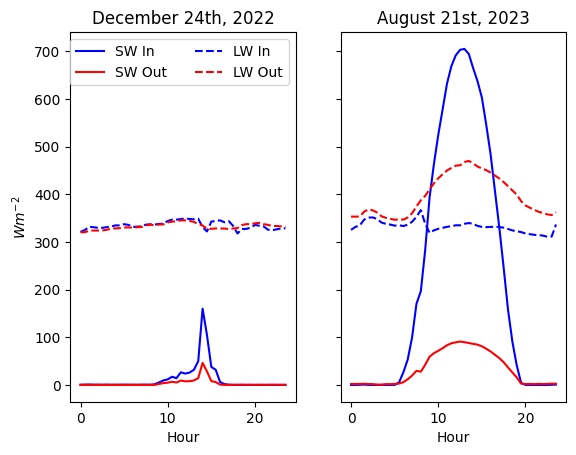

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

# Import the data from github & parse the timestamp for each record
data_url='https://raw.githubusercontent.com/GEOS300/AssignmentData/main/Climate_Summary_BB.csv'
# Pandas (pd here) allows us to set a timestamp as an index which lets us easily parse time series data
df = pd.read_csv(data_url,parse_dates=['TIMESTAMP'],index_col=['TIMESTAMP'])
fig,ax=plt.subplots(1,2,sharey=True,sharex=True)
# fig.autofmt_xdate(rotation=45)
df['Hour'] = df.index.hour+df.index.minute/60
wx = df.loc[((df.index.year==2022)&(df.index.month==12)&(df.index.day==24))]
su = df.loc[((df.index.year==2023)&(df.index.month==8)&(df.index.day==21))]
wx.plot(ax=ax[0],x='Hour',y=['SW_IN_1_1_1','SW_OUT_1_1_1','LW_IN_1_1_1','LW_OUT_1_1_1'],
              color=['blue','red','blue','red'],
              style=['-','-','--','--'])
ax[0].set_title('December 24th, 2022')
ax[0].legend(['SW In','SW Out','LW In','LW Out'],ncol=2)
ax[0].set_ylabel('$W m^{-2}$')
        
ax[1].set_title('August 21st, 2023')
su.plot(ax=ax[1],x='Hour',y=['SW_IN_1_1_1','SW_OUT_1_1_1','LW_IN_1_1_1','LW_OUT_1_1_1'],
              color=['blue','red','blue','red'],
              style=['-','-','--','--'],legend=False)


Text(0, 0.5, '$MJ m^{-2} d^{-1}$')

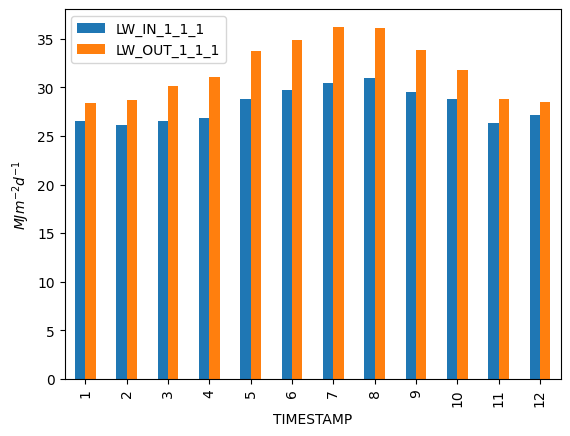

In [93]:
Monthly = df.loc[df.index.year<=2024].resample('M').mean()[['LW_IN_1_1_1','LW_OUT_1_1_1']]

Monthly = Monthly.groupby(Monthly.index.month).mean()*3600*24*1e-6
fig,ax=plt.subplots()
Monthly.plot(kind='bar',y=['LW_IN_1_1_1','LW_OUT_1_1_1'],ax=ax)
ax.set_ylabel('$MJ m^{-2} d^{-1}$')

In [103]:
import numpy as np

class get_epsilon_a():
  def __init__(self,T_a,RH):
    if T_a < 100:
      self.T_a = T_a
      self.T_ak = T_a+273.15
    else:
      self.T_ak=T_a
      self.T_a=T_a-273.15
    if RH>1:
      self.RH=RH*.01
    else:
      self.RH=RH
    self.Prata()

  def Prata(self):
    self.Pv_from_RH()
    a = 1.2
    b = 3
    zeta = 46.5*(self.P_v/self.T_ak)
    self.epsilon_a = 1-(1+zeta)*np.exp(-(a+b*zeta)**0.5)

  def Pv_from_RH(self):
    P_v_star = 6.112*np.exp(17.62*self.T_a/(243.12+self.T_a))
    self.P_v = self.RH*P_v_star
e = get_epsilon_a(9,80)

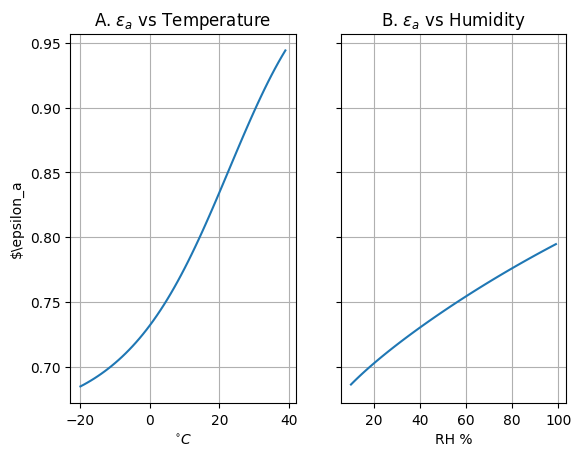

In [121]:
fig,ax=plt.subplots(1,2,sharey=True)
RH=np.arange(10,100)
TA=np.arange(-20,40)
RH_e = np.array([get_epsilon_a(10,rh).epsilon_a for rh in RH]) 
TA_e = np.array([get_epsilon_a(ta,80).epsilon_a for ta in TA]) 
ax[0].plot(TA,TA_e)
ax[0].set_title('A. $\epsilon_a$ vs Temperature')
ax[0].set_xlabel('$^{\circ} C$')
ax[0].set_ylabel('$\epsilon_a')
ax[0].grid()
ax[1].plot(RH,RH_e)
ax[1].set_title('B. $\epsilon_a$ vs Humidity')
ax[1].set_xlabel('RH %')
ax[1].grid()